<a href="https://colab.research.google.com/github/pen1064/Food_Image_Query/blob/main/Food_Image_Similarity_Search_Preliminary_Proof_of_Concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [43]:
import glob
import time
from PIL import Image
import pandas as pd 
import torch 
import torch.nn as nn
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

In [3]:
train_df = pd.read_csv(r'/content/gdrive/MyDrive/Food/train_google.csv')
test_df = pd.read_csv(r'/content/gdrive/MyDrive/Food/test_google.csv')

In [4]:
class MakeDataset(torch.utils.data.Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    self.dish_cat = {x: i+1 for i,x in enumerate(self.df['dish'].unique())}
    self.imgs =df['filename'].unique()

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    img_path = self.imgs[idx]
    img = Image.open(img_path).convert("RGB")
    img = self.transform(img)
    ll = self.df[self.df['filename'] == img_path]['dish'].values
    label = torch.as_tensor(self.dish_cat[ll[0]], dtype=torch.int64)
    return img, label

tc = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = MakeDataset(train_df, transform=tc)
test_dataset = MakeDataset(test_df, transform=tc)


In [80]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

In [6]:
# data loader 
def feature_extraction(m, data_loader):
  embeddings = []
  m.to(device)
  m.eval()
  for imgs, labels in data_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
      batch_embeddings = m(imgs)
    #imgs.to(torch.device('cpu'))
    batch_embeddings.to(torch.device('cpu'))
    embeddings.append(torch.squeeze(batch_embeddings))
    del batch_embeddings
  return embeddings

In [7]:
model_f = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model_f.children())[:-1])
#model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
embeddings = feature_extraction(model, train_data_loader)

In [15]:
print(type(embeddings))

<class 'list'>


In [26]:
flatten_embeddings = [torch.Tensor.tolist(x) for e in embeddings for x in e ]

In [30]:
test_embed = pd.DataFrame(columns=['filename', 'dish', 'embedding'])
test_embed['embedding'] = flatten_embeddings
test_embed['filename'] = train_df['filename']
test_embed['dish'] = train_df['dish']
test_embed.to_csv('/content/gdrive/MyDrive/Food/test_embeding.csv', index=False )

In [31]:
!pip install annoy

     |████████████████████████████████| 646 kB 8.6 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391568 sha256=a32f7dab71064dbf0255d886edb1e81ab5fb7e5a9351bee21ec7707502d74a3b
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [182]:
from annoy import AnnoyIndex
f = 512 
num_tree = 100
a = AnnoyIndex(f, metric = 'angular')
for i in range(len(flatten_embeddings)):
  a.add_item(i, flatten_embeddings[i])
a.build(num_tree)

a.save('/content/gdrive/MyDrive/Food/encoding_'+str(num_tree) +'_resnet18.ann')

True

In [183]:
count = 0
test_embeddings = []
for imgs, labels in test_data_loader:
  if count < 10:
    imgs = imgs.to(device)
    with torch.no_grad():
      test_batch_embeddings = model(imgs)
      count += 1
      test_batch_embeddings = torch.squeeze(test_batch_embeddings)
      test_embeddings.append(test_batch_embeddings)
  else:
    break


In [184]:
#test_batch_embeddings = torch.Tensor.tolist(test_batch_embeddings)
test_embeddings = [torch.Tensor.tolist(x) for e in test_embeddings for x in e ]

If user upload this:


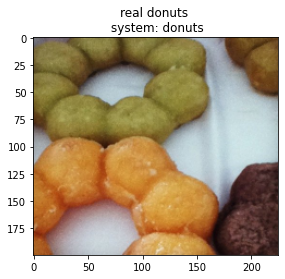

These are the photos that system will roll out:


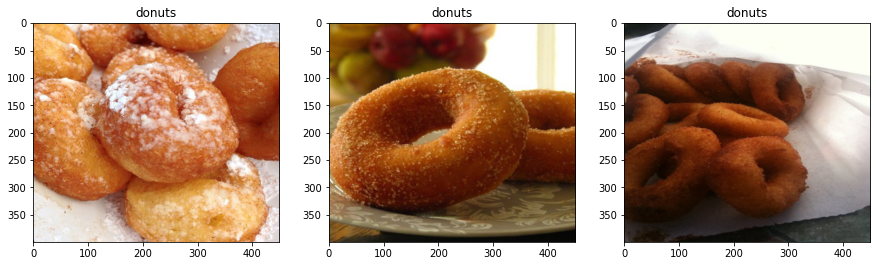

If user upload this:


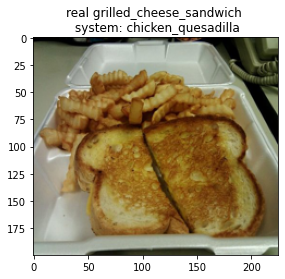

These are the photos that system will roll out:


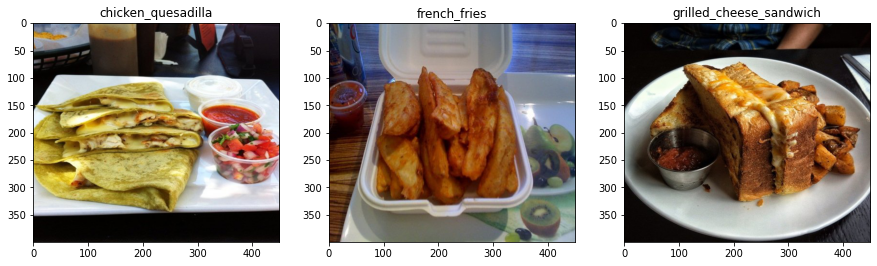

If user upload this:


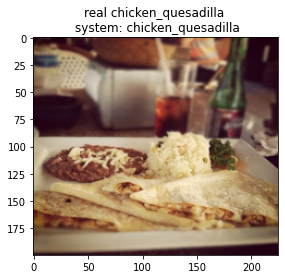

These are the photos that system will roll out:


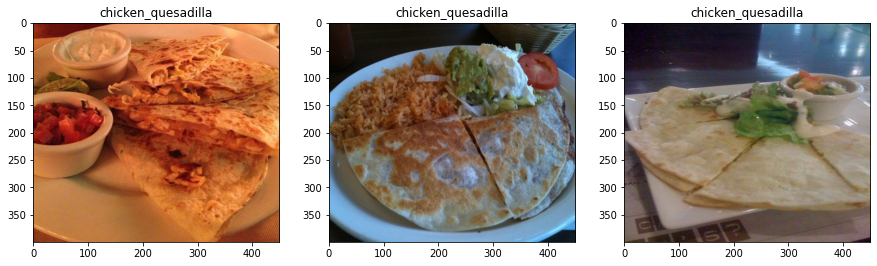

If user upload this:


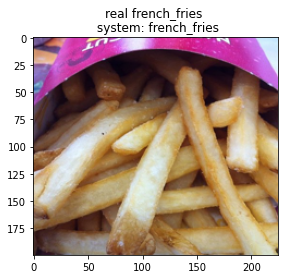

These are the photos that system will roll out:


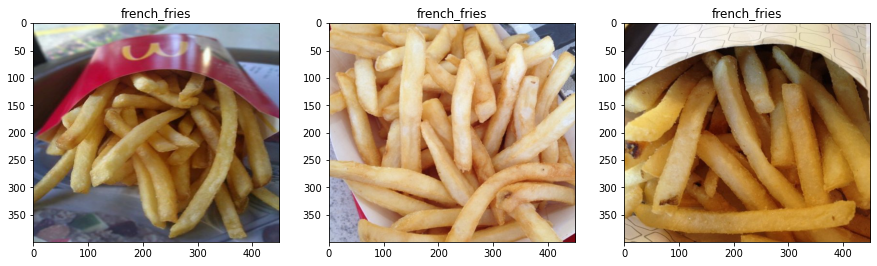

If user upload this:


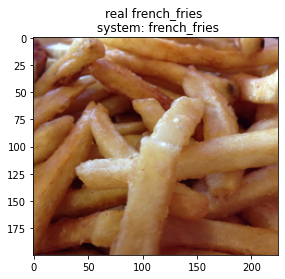

These are the photos that system will roll out:


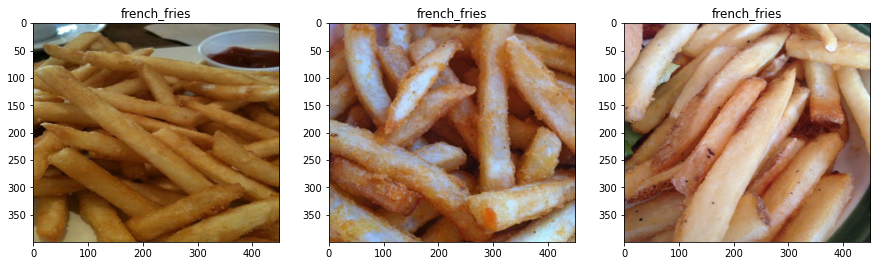

If user upload this:


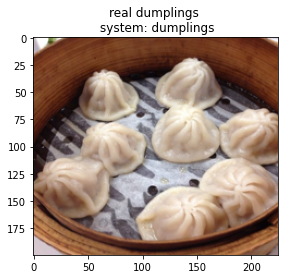

These are the photos that system will roll out:


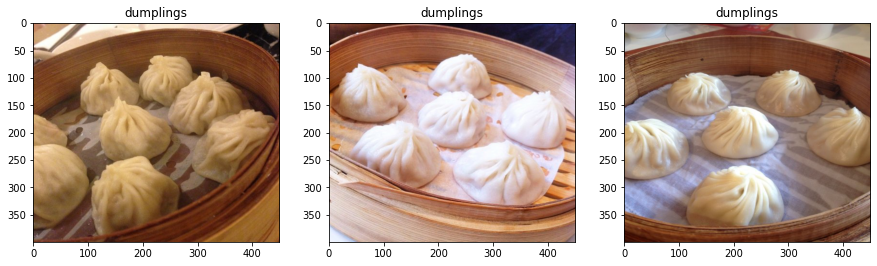

If user upload this:


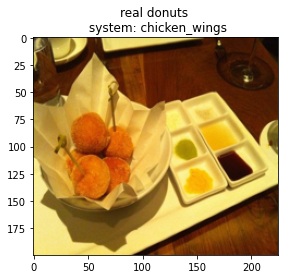

These are the photos that system will roll out:


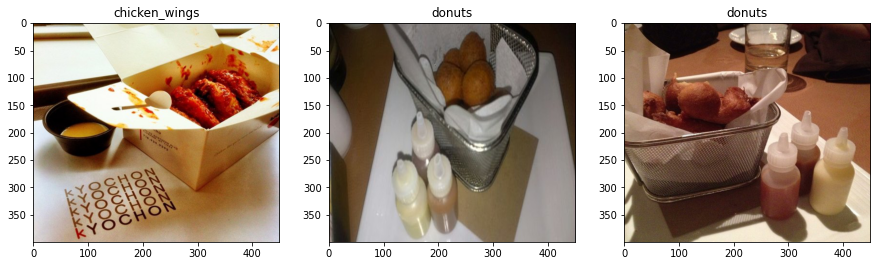

If user upload this:


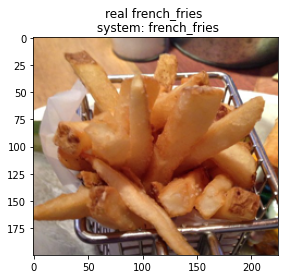

These are the photos that system will roll out:


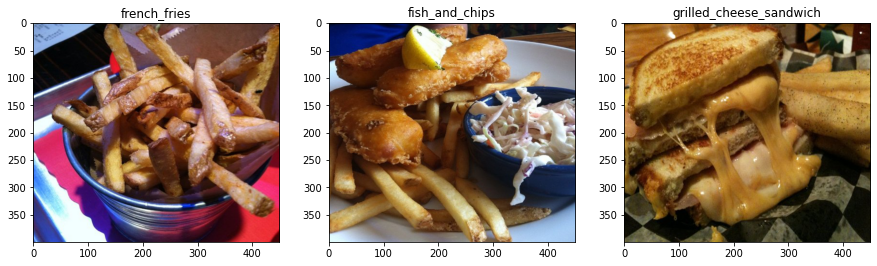

If user upload this:


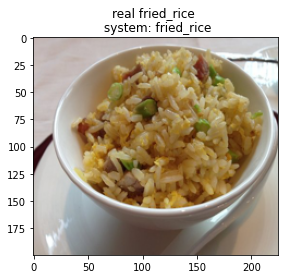

These are the photos that system will roll out:


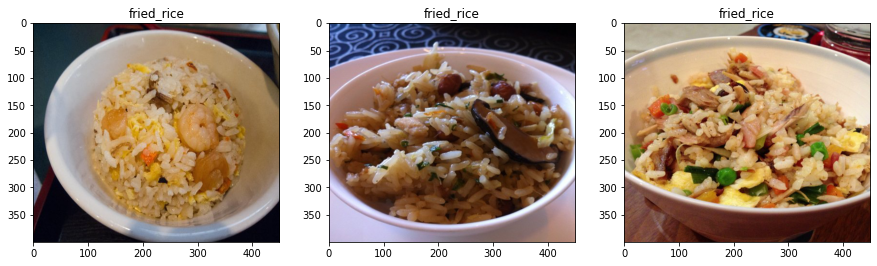

If user upload this:


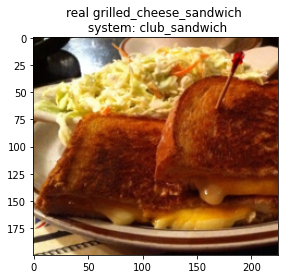

These are the photos that system will roll out:


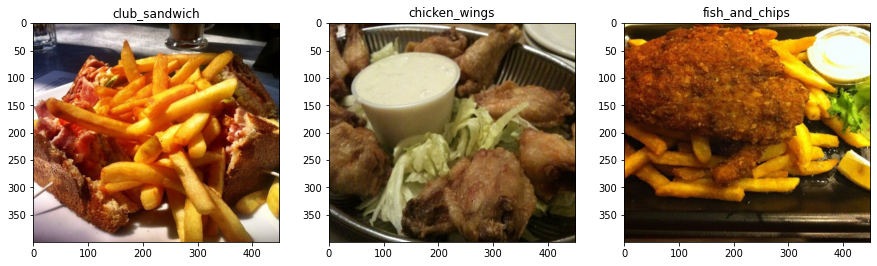

In [186]:
for i in range(10):
  test_img = Image.open(test_df.loc[i, 'filename'])
  test_img = test_img.convert('RGB')
  test_img = test_img.resize([225, 200])
  searches = a.get_nns_by_vector(test_embeddings[i], 10, include_distances=True)
  #print(searches)

  #print(train_df.loc[searches[0][0], 'dish'])
  print('If user upload this:')
  plt.figure()
  plt.imshow(test_img)
  t = 'real ' + test_df.loc[i, 'dish'] + ' \n system: ' + train_df.loc[searches[0][0], 'dish']
  plt.title(t)
  plt.show()

  print('These are the photos that system will roll out:')
  fig = plt.figure(figsize=[15,15])
  count = 0
  for count in range(3):
    plt.subplot(1, 3, count+1)
    img = Image.open(train_df.loc[searches[0][count], 'filename'])
    img = img.resize([450, 400])
    plt.imshow(img)
    plt.title(train_df.loc[searches[0][count], 'dish'])
    count += 1
  plt.show()
